In [1]:
from activ import load_data, data_normalization
import os
from activ.readfile import TrackTBIFile
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from activ.analytics import heatmap, nmf_bases_heatmap
from activ.clustering import UmapClusteringResults
from os.path import dirname, join
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display, Latex, Markdown
from pylatex import Document, Section, Subsection, Command
from pylatex import Document, Section, Figure, SubFigure, NoEscape
from pylatex.utils import italic, NoEscape
from scipy.stats import norm, sem

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def conf_alliter(size, predicted, actual):
    confalliter = []
    for j in range(50):
        conf = np.zeros((size,size))
        labs = list(map(int, actual[j][size-2]))
        preds = list(map(int, predicted[j][size-2]))
        for l, p in zip(labs, preds):
            conf[l,p] += 1
        confalliter.append(conf)
    return confalliter

In [3]:
def accuracy(mat):
    return mat.trace()/mat.sum()

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


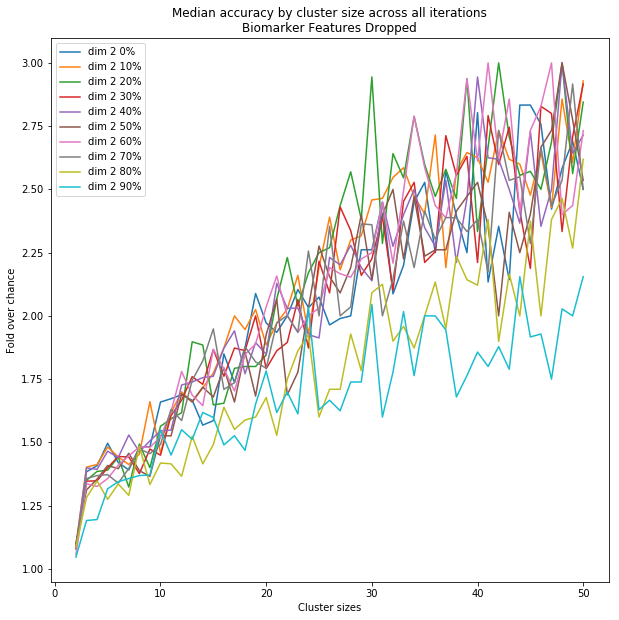

In [11]:
percent = [0,10,20,30,40,50,60,70,80,90]

for ii,p in enumerate(percent):
    path = '/Users/ahyeon/Desktop/activ/results/no_transform/bm_drop_{}_result.h5'.format(p)
    f = h5py.File(path, 'r')
    predictions = np.squeeze(f['score'][:], axis=1)
    norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
    cluster_sizes = f['cluster_sizes'][:]
    labels = np.squeeze(f['clusters'][:], axis=1)
    fold_over_chance = np.zeros((len(cluster_sizes), 50))
    raw_acc = np.zeros((len(cluster_sizes), 50))
    normalized_acc = np.zeros((len(cluster_sizes), 50))
    for jj,c in enumerate(cluster_sizes):
        all50mat = conf_alliter(c, predictions, labels)
        norm_all50mat = conf_alliter(c, norm_predictions, labels)
        acc = [accuracy(i) for i in all50mat]
        norm_acc = [accuracy(i) for i in norm_all50mat]
        foc = [float(x/y) for x, y in zip(acc, norm_acc)]
        fold_over_chance[jj,:] = foc
        raw_acc[jj,:] = acc
        normalized_acc[jj,:] = norm_acc
   
    
    plt.rcParams["figure.figsize"] = [10,10]
    cmap = plt.get_cmap("tab10")
    plt.plot(cluster_sizes, np.median(fold_over_chance, axis=1), label='dim 2 {}%'.format(p), color = cmap(ii))
#     plt.plot(cluster_sizes, np.median(raw_acc, axis=1), label='raw')
#     plt.plot(cluster_sizes, np.median(normalized_acc, axis=1), label='chance')
    
    plt.title("Median accuracy by cluster size across all iterations\nBiomarker Features Dropped")
    plt.xlabel("Cluster sizes")
    plt.ylabel("Fold over chance")
    plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/no_transform_bm_dropped.pdf')

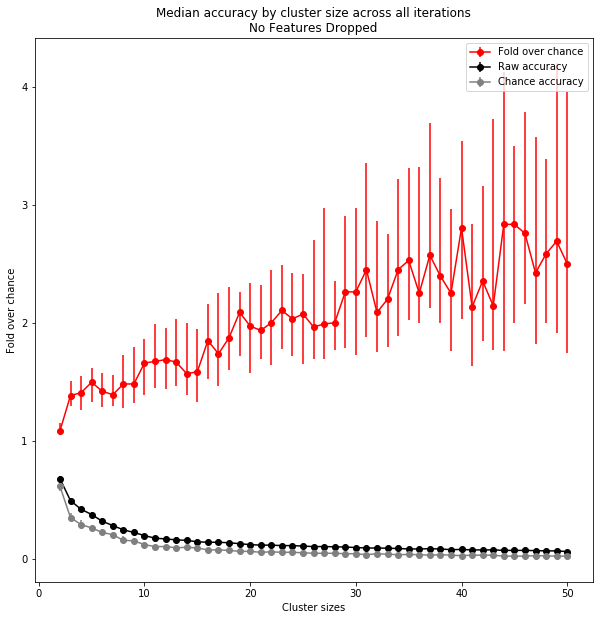

In [17]:
# all outcomes and biomarkers

percent = [0,10,20,30,40,50,60,70,80,90]

for ii,p in enumerate([percent[0]]):
    path = '/Users/ahyeon/Desktop/activ/results/no_transform/bm_drop_{}_result.h5'.format(p)
    f = h5py.File(path, 'r')
    predictions = np.squeeze(f['score'][:], axis=1)
    norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
    cluster_sizes = f['cluster_sizes'][:]
    labels = np.squeeze(f['clusters'][:], axis=1)
    fold_over_chance = np.zeros((len(cluster_sizes), 50))
    raw_acc = np.zeros((len(cluster_sizes), 50))
    normalized_acc = np.zeros((len(cluster_sizes), 50))
    for jj,c in enumerate(cluster_sizes):
        all50mat = conf_alliter(c, predictions, labels)
        norm_all50mat = conf_alliter(c, norm_predictions, labels)
        acc = [accuracy(i) for i in all50mat]
        norm_acc = [accuracy(i) for i in norm_all50mat]
        foc = [float(x/y) for x, y in zip(acc, norm_acc)]
        fold_over_chance[jj,:] = foc
        raw_acc[jj,:] = acc
        normalized_acc[jj,:] = norm_acc
   
    
    plt.rcParams["figure.figsize"] = [10,10]
    cmap = plt.get_cmap("tab10")
    lower = [np.percentile(fold_over_chance[i,:], 25) for i in range(49)]
    upper = [np.percentile(fold_over_chance[i,:], 75) for i in range(49)]
    med = np.median(fold_over_chance, axis=1)
    raw_med = np.median(raw_acc, axis=1)
    raw_lower = [np.percentile(raw_acc[i,:], 25) for i in range(49)]
    raw_upper = [np.percentile(raw_acc[i,:], 75) for i in range(49)]
    norm_med = np.median(normalized_acc, axis=1)
    norm_lower = [np.percentile(normalized_acc[i,:], 25) for i in range(49)]
    norm_upper = [np.percentile(normalized_acc[i,:], 75) for i in range(49)]
    
    plt.errorbar(cluster_sizes, med, yerr=[med-lower,upper-med], color = 'red',fmt='-o', label='Fold over chance')
    plt.errorbar(cluster_sizes, raw_med, yerr=[raw_med-raw_lower,raw_upper-raw_med], color='black',fmt='-o', label='Raw accuracy')
    plt.errorbar(cluster_sizes, norm_med, yerr=[norm_med-norm_lower, norm_upper-norm_med], color='grey',fmt='-o', label='Chance accuracy')
#     plt.errorbar(cluster_sizes, np.median(fold_over_chance, axis=1), yerr=2*std, color='red', label='Fold over chance')
#     plt.errorbar(cluster_sizes, np.median(raw_acc, axis=1), yerr=2*raw_std, color='black', label='raw')
#     plt.errorbar(cluster_sizes, np.median(normalized_acc, axis=1), yerr=2*norm_std, color='grey', label='chance')

#     plt.plot(cluster_sizes, np.median(fold_over_chance, axis=1), label='fold over chance', color = 'red')
#     plt.plot(cluster_sizes, np.median(raw_acc, axis=1), label='raw', color='black')
#     plt.plot(cluster_sizes, np.median(normalized_acc, axis=1), label='chance', color='grey')
    
    plt.title("Median accuracy by cluster size across all iterations\nNo Features Dropped")
    plt.xlabel("Cluster sizes")
    plt.ylabel("Fold over chance")
    plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/no_transform_error_bars.pdf')

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


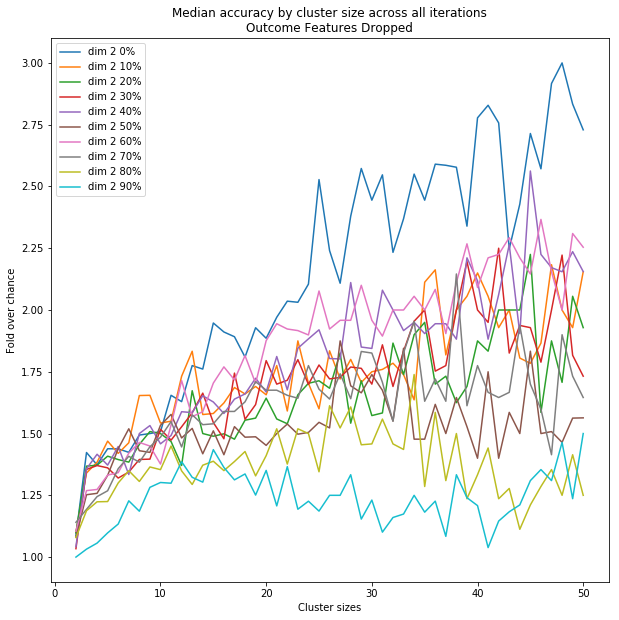

In [9]:
percent = [0,10,20,30,40,50,60,70,80,90]

for ii,p in enumerate(percent):
    path = '/Users/ahyeon/Desktop/activ/results/no_transform/oc_drop_{}_result.h5'.format(p)
    f = h5py.File(path, 'r')
    predictions = np.squeeze(f['score'][:], axis=1)
    norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
    cluster_sizes = f['cluster_sizes'][:]
    labels = np.squeeze(f['clusters'][:], axis=1)
    fold_over_chance = np.zeros((len(cluster_sizes), 50))
    raw_acc = np.zeros((len(cluster_sizes), 50))
    normalized_acc = np.zeros((len(cluster_sizes), 50))
    for jj,c in enumerate(cluster_sizes):
        all50mat = conf_alliter(c, predictions, labels)
        norm_all50mat = conf_alliter(c, norm_predictions, labels)
        acc = [accuracy(i) for i in all50mat]
        norm_acc = [accuracy(i) for i in norm_all50mat]
        foc = [float(x/y) for x, y in zip(acc, norm_acc)]
        fold_over_chance[jj,:] = foc
        raw_acc[jj,:] = acc
        normalized_acc[jj,:] = norm_acc
   
    
    plt.rcParams["figure.figsize"] = [10,10]
    cmap = plt.get_cmap("tab10")
    plt.plot(cluster_sizes, np.median(fold_over_chance, axis=1), label='dim 2 {}%'.format(p), color = cmap(ii))
#     plt.plot(cluster_sizes, np.median(raw_acc, axis=1), label='raw')
#     plt.plot(cluster_sizes, np.median(normalized_acc, axis=1), label='chance')
    
    plt.title("Median accuracy by cluster size across all iterations\nOutcome Features Dropped")
    plt.xlabel("Cluster sizes")
    plt.ylabel("Fold over chance")
    plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/no_transform_oc_dropped.pdf')